In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.metrics import r2_score
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import renom as rm
from renom.optimizer import Adam

from renom_rg.api.regression.gcnn import GCNet
from renom_rg.api.utility.feature_graph import get_corr_graph, get_kernel_graph, get_dbscan_graph

np.random.seed(1984)

In [2]:
batch_size = 16
epochs = 100
fc_unit = (100, 50)
channels = (10, 20, 20)
neighbors = 5
gamma = 0.1

In [3]:
boston_data = load_boston()

X = boston_data.data
y = boston_data.target.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [4]:
# feature_graph = get_corr_graph(X_train, neighbors)
# feature_graph = get_kernel_graph(X_train, neighbors, gamma)
feature_graph = get_dbscan_graph(X_train, neighbors)

In [5]:
network = GCNet(feature_graph=feature_graph, num_target=y_train.shape[1], neighbors=neighbors, fc_unit=fc_unit, channels=channels)
optimizer = Adam()

learning_curve = []
test_curve = []

for i in range(epochs):
    N = X_train.shape[0]
    perm = np.random.permutation(N)
    loss = 0
    bar = tqdm(range(N//batch_size))
    for j in bar:
        index = perm[j*batch_size:(j+1)*batch_size]
        train_batch_x = X_train[index].reshape(-1, 1, X_train.shape[1], 1)
        train_batch_y = y_train[index]

        # Loss function
        network.set_models(inference=False)
        with network.train():
            l = rm.mse(network(train_batch_x), train_batch_y)

        # Back propagation
        grad = l.grad()

        # Update
        grad.update(optimizer)
        loss += l.as_ndarray()
        bar.set_description("epoch: {} loss: {}".format(i, l.as_ndarray()))
        bar.update(1)
        
    train_loss = loss / (N//batch_size)
    learning_curve.append(train_loss)

    # Validation
    network.set_models(inference=True)
    N = X_test.shape[0]
    
    pred = network(X_test.reshape(-1, 1, X_test.shape[1], 1))
    test_loss = rm.mse(pred, y_test)
    test_curve.append(test_loss)
    print("epoch:{} train_loss: {} test_loss: {}".format(i, train_loss, test_loss))
    print("epoch {} R2:{}".format(i, r2_score(y_test, pred)))

epoch: 1 loss: 34.53654479980469:  64%|██████▍   | 16/25 [00:00<00:00, 84.66it/s] 

epoch:0 train_loss: 94.66545715332032 test_loss: 28.00143814086914
epoch 0 R2:0.232709735528833


epoch: 2 loss: 12.735286712646484:  56%|█████▌    | 14/25 [00:00<00:00, 78.66it/s]

epoch:1 train_loss: 34.98801689147949 test_loss: 22.311609268188477
epoch 1 R2:0.38862142521372467


epoch: 3 loss: 39.04886245727539:  60%|██████    | 15/25 [00:00<00:00, 77.48it/s] 

epoch:2 train_loss: 28.9895796585083 test_loss: 16.314342498779297
epoch 2 R2:0.5529572945745695


epoch: 4 loss: 23.675376892089844:  64%|██████▍   | 16/25 [00:00<00:00, 86.15it/s]

epoch:3 train_loss: 21.66054473876953 test_loss: 13.889755249023438
epoch 3 R2:0.6193954675772702


epoch: 5 loss: 4.656487464904785:  56%|█████▌    | 14/25 [00:00<00:00, 81.93it/s] 

epoch:4 train_loss: 18.13783582687378 test_loss: 12.400525093078613
epoch 4 R2:0.6602030080941077


epoch: 6 loss: 17.882646560668945:  64%|██████▍   | 16/25 [00:00<00:00, 80.79it/s]

epoch:5 train_loss: 13.153290004730225 test_loss: 10.25662899017334
epoch 5 R2:0.7189497529947138


epoch: 7 loss: 7.9678473472595215:  60%|██████    | 15/25 [00:00<00:00, 85.57it/s]

epoch:6 train_loss: 13.849942378997802 test_loss: 9.28083324432373
epoch 6 R2:0.7456883132665069


epoch: 8 loss: 17.757461547851562:  56%|█████▌    | 14/25 [00:00<00:00, 88.90it/s]

epoch:7 train_loss: 10.865447025299073 test_loss: 9.711108207702637
epoch 7 R2:0.733897993758193


epoch: 9 loss: 6.855777740478516:  60%|██████    | 15/25 [00:00<00:00, 82.38it/s] 

epoch:8 train_loss: 10.784581222534179 test_loss: 9.404420852661133
epoch 8 R2:0.7423017918669645


epoch: 10 loss: 13.483345985412598:  44%|████▍     | 11/25 [00:00<00:00, 78.09it/s]

epoch:9 train_loss: 8.857381715774537 test_loss: 8.76530647277832
epoch 9 R2:0.7598146780258137


epoch: 11 loss: 6.491394519805908:  60%|██████    | 15/25 [00:00<00:00, 80.11it/s] 

epoch:10 train_loss: 10.132697381973266 test_loss: 9.925787925720215
epoch 10 R2:0.7280153722152147


epoch: 12 loss: 5.464684009552002:  56%|█████▌    | 14/25 [00:00<00:00, 79.03it/s] 

epoch:11 train_loss: 10.854047298431396 test_loss: 9.925643920898438
epoch 11 R2:0.7280192965173834


epoch: 13 loss: 7.676680564880371:  60%|██████    | 15/25 [00:00<00:00, 86.54it/s]

epoch:12 train_loss: 10.0214084815979 test_loss: 10.345266342163086
epoch 12 R2:0.7165209108443004


epoch: 14 loss: 3.7779531478881836:  56%|█████▌    | 14/25 [00:00<00:00, 79.09it/s]

epoch:13 train_loss: 9.412855319976806 test_loss: 9.8710298538208
epoch 13 R2:0.7295158448820438


epoch: 15 loss: 7.542410850524902:  60%|██████    | 15/25 [00:00<00:00, 86.01it/s] 

epoch:14 train_loss: 8.178569946289063 test_loss: 10.681195259094238
epoch 14 R2:0.707315858649237


epoch: 16 loss: 4.237080097198486:  60%|██████    | 15/25 [00:00<00:00, 80.38it/s] 

epoch:15 train_loss: 9.745396118164063 test_loss: 10.811874389648438
epoch 15 R2:0.703735043201954


epoch: 17 loss: 3.7310171127319336:  56%|█████▌    | 14/25 [00:00<00:00, 82.11it/s]

epoch:16 train_loss: 9.470083770751954 test_loss: 11.20483684539795
epoch 16 R2:0.6929671048203225


epoch: 18 loss: 15.911972999572754:  60%|██████    | 15/25 [00:00<00:00, 83.91it/s]

epoch:17 train_loss: 8.43624969482422 test_loss: 10.628158569335938
epoch 17 R2:0.7087691644596427


epoch: 19 loss: 4.167117595672607:  60%|██████    | 15/25 [00:00<00:00, 83.91it/s] 

epoch:18 train_loss: 7.850875015258789 test_loss: 9.989581108093262
epoch 18 R2:0.7262673011812839


epoch: 20 loss: 3.544929027557373:  56%|█████▌    | 14/25 [00:00<00:00, 80.15it/s]

epoch:19 train_loss: 8.31169225215912 test_loss: 12.532926559448242
epoch 19 R2:0.6565750309002458


epoch: 21 loss: 3.5501599311828613:  56%|█████▌    | 14/25 [00:00<00:00, 88.92it/s]

epoch:20 train_loss: 7.969590482711792 test_loss: 11.902652740478516
epoch 20 R2:0.6738456549887797


epoch: 22 loss: 3.2076380252838135:  52%|█████▏    | 13/25 [00:00<00:00, 80.13it/s]

epoch:21 train_loss: 8.30447841644287 test_loss: 12.133492469787598
epoch 21 R2:0.6675202769270321


epoch: 23 loss: 4.163081645965576:  52%|█████▏    | 13/25 [00:00<00:00, 81.20it/s] 

epoch:22 train_loss: 7.617857780456543 test_loss: 10.29395580291748
epoch 22 R2:0.7179269009370178


epoch: 24 loss: 19.982563018798828:  56%|█████▌    | 14/25 [00:00<00:00, 73.85it/s]

epoch:23 train_loss: 8.210876302719116 test_loss: 9.613094329833984
epoch 23 R2:0.7365837277775866


epoch: 25 loss: 3.3374593257904053:  60%|██████    | 15/25 [00:00<00:00, 84.57it/s]

epoch:24 train_loss: 6.881076278686524 test_loss: 12.322641372680664
epoch 24 R2:0.6623372324090022


epoch: 26 loss: 5.265045642852783:  40%|████      | 10/25 [00:00<00:00, 59.45it/s]

epoch:25 train_loss: 8.232994413375854 test_loss: 11.21477222442627
epoch 25 R2:0.6926949090668157


epoch: 27 loss: 3.4768378734588623:  36%|███▌      | 9/25 [00:00<00:00, 56.90it/s]

epoch:26 train_loss: 7.585146408081055 test_loss: 11.509708404541016
epoch 26 R2:0.6846131137613154


epoch: 28 loss: 9.295051574707031:  44%|████▍     | 11/25 [00:00<00:00, 71.42it/s]

epoch:27 train_loss: 6.44835976600647 test_loss: 9.988635063171387
epoch 27 R2:0.7262932733039219


epoch: 29 loss: 6.519505500793457:  56%|█████▌    | 14/25 [00:00<00:00, 78.49it/s] 

epoch:28 train_loss: 7.563338584899903 test_loss: 12.403199195861816
epoch 28 R2:0.6601298112481953


epoch: 30 loss: 12.140029907226562:  52%|█████▏    | 13/25 [00:00<00:00, 69.60it/s]

epoch:29 train_loss: 7.096586761474609 test_loss: 10.233498573303223
epoch 29 R2:0.719583529041584


epoch: 31 loss: 4.739843845367432:  56%|█████▌    | 14/25 [00:00<00:00, 78.55it/s]

epoch:30 train_loss: 6.892314310073853 test_loss: 10.959187507629395
epoch 30 R2:0.6996983833309021


epoch: 32 loss: 7.303749084472656:  56%|█████▌    | 14/25 [00:00<00:00, 79.69it/s] 

epoch:31 train_loss: 6.875078468322754 test_loss: 10.899666786193848
epoch 31 R2:0.7013293250787058


epoch: 33 loss: 9.689590454101562:  56%|█████▌    | 14/25 [00:00<00:00, 73.41it/s]

epoch:32 train_loss: 6.918048830032348 test_loss: 11.209952354431152
epoch 32 R2:0.6928269454252354


epoch: 34 loss: 2.6857752799987793:  56%|█████▌    | 14/25 [00:00<00:00, 76.76it/s]

epoch:33 train_loss: 6.526600790023804 test_loss: 10.017539978027344
epoch 33 R2:0.7255011704372392


epoch: 35 loss: 9.267476081848145:  60%|██████    | 15/25 [00:00<00:00, 85.90it/s] 

epoch:34 train_loss: 7.53095645904541 test_loss: 10.043514251708984
epoch 34 R2:0.7247894744267815


epoch: 36 loss: 6.91247034072876:  56%|█████▌    | 14/25 [00:00<00:00, 76.87it/s]  

epoch:35 train_loss: 8.678114595413208 test_loss: 11.92033576965332
epoch 35 R2:0.6733612195830116


epoch: 37 loss: 5.438968181610107:  56%|█████▌    | 14/25 [00:00<00:00, 78.49it/s] 

epoch:36 train_loss: 7.8567582130432125 test_loss: 9.428582191467285
epoch 36 R2:0.7416397089797772


epoch: 38 loss: 3.7358641624450684:  52%|█████▏    | 13/25 [00:00<00:00, 66.97it/s]

epoch:37 train_loss: 6.363377418518066 test_loss: 8.865574836730957
epoch 37 R2:0.7570671603568153


epoch: 39 loss: 6.549629211425781:  56%|█████▌    | 14/25 [00:00<00:00, 75.41it/s] 

epoch:38 train_loss: 5.960547018051147 test_loss: 11.55474853515625
epoch 38 R2:0.6833788687194783


epoch: 40 loss: 5.961014747619629:  48%|████▊     | 12/25 [00:00<00:00, 82.71it/s]

epoch:39 train_loss: 6.636911039352417 test_loss: 9.403583526611328
epoch 39 R2:0.7423247117653167


epoch: 41 loss: 2.8990721702575684:  44%|████▍     | 11/25 [00:00<00:00, 62.28it/s]

epoch:40 train_loss: 7.431150989532471 test_loss: 8.623719215393066
epoch 40 R2:0.7636944305097584


epoch: 42 loss: 4.258244514465332:  48%|████▊     | 12/25 [00:00<00:00, 63.06it/s]

epoch:41 train_loss: 6.422849969863892 test_loss: 10.070551872253418
epoch 41 R2:0.7240485500144725


epoch: 43 loss: 3.7810521125793457:  56%|█████▌    | 14/25 [00:00<00:00, 74.46it/s]

epoch:42 train_loss: 6.709099001884461 test_loss: 8.855317115783691
epoch 42 R2:0.7573482084091516


epoch: 44 loss: 21.430578231811523:  56%|█████▌    | 14/25 [00:00<00:00, 78.64it/s]

epoch:43 train_loss: 7.069409017562866 test_loss: 8.971014022827148
epoch 43 R2:0.7541779280823346


epoch: 45 loss: 8.717103958129883:  60%|██████    | 15/25 [00:00<00:00, 76.46it/s] 

epoch:44 train_loss: 6.211592693328857 test_loss: 11.69997501373291
epoch 44 R2:0.6793994274172054


epoch: 46 loss: 5.335055351257324:  60%|██████    | 15/25 [00:00<00:00, 79.73it/s] 

epoch:45 train_loss: 6.553935270309449 test_loss: 10.703633308410645
epoch 45 R2:0.7067010242166549


epoch: 47 loss: 7.111156463623047:  56%|█████▌    | 14/25 [00:00<00:00, 81.12it/s] 

epoch:46 train_loss: 6.342604055404663 test_loss: 11.41537857055664
epoch 46 R2:0.6871978162217633


epoch: 48 loss: 6.756425857543945:  56%|█████▌    | 14/25 [00:00<00:00, 78.66it/s] 

epoch:47 train_loss: 6.401936511993409 test_loss: 10.466551780700684
epoch 47 R2:0.7131974595564519


epoch: 49 loss: 5.072226524353027:  56%|█████▌    | 14/25 [00:00<00:00, 77.12it/s]

epoch:48 train_loss: 6.251642255783081 test_loss: 11.218759536743164
epoch 48 R2:0.6925855862513486


epoch: 50 loss: 6.008556365966797:  52%|█████▏    | 13/25 [00:00<00:00, 74.19it/s]

epoch:49 train_loss: 6.8260031509399415 test_loss: 10.719849586486816
epoch 49 R2:0.7062566210991414


epoch: 51 loss: 9.127203941345215:  52%|█████▏    | 13/25 [00:00<00:00, 79.77it/s] 

epoch:50 train_loss: 5.321292562484741 test_loss: 9.23405647277832
epoch 50 R2:0.7469700855363455


epoch: 52 loss: 3.0349974632263184:  60%|██████    | 15/25 [00:00<00:00, 85.71it/s]

epoch:51 train_loss: 6.018165512084961 test_loss: 9.705111503601074
epoch 51 R2:0.7340623182625168


epoch: 53 loss: 3.4017343521118164:  56%|█████▌    | 14/25 [00:00<00:00, 71.47it/s]

epoch:52 train_loss: 5.608750877380371 test_loss: 10.249475479125977
epoch 52 R2:0.7191457106402606


epoch: 54 loss: 3.3048672676086426:  56%|█████▌    | 14/25 [00:00<00:00, 82.80it/s]

epoch:53 train_loss: 5.069698610305786 test_loss: 9.103653907775879
epoch 53 R2:0.7505433306735555


epoch: 55 loss: 5.601640224456787:  48%|████▊     | 12/25 [00:00<00:00, 66.46it/s]

epoch:54 train_loss: 5.626608490943909 test_loss: 10.912530899047852
epoch 54 R2:0.70097680460223


epoch: 56 loss: 17.40412139892578:  52%|█████▏    | 13/25 [00:00<00:00, 79.72it/s] 

epoch:55 train_loss: 5.833996725082398 test_loss: 8.432740211486816
epoch 55 R2:0.7689276242764252


epoch: 57 loss: 7.05559778213501:  52%|█████▏    | 13/25 [00:00<00:00, 72.83it/s]  

epoch:56 train_loss: 5.838300924301148 test_loss: 12.01413345336914
epoch 56 R2:0.6707909308291111


epoch: 58 loss: 3.5979950428009033:  52%|█████▏    | 13/25 [00:00<00:00, 76.09it/s]

epoch:57 train_loss: 6.313177680969238 test_loss: 8.094805717468262
epoch 57 R2:0.7781876041763798


epoch: 59 loss: 3.513761043548584:  48%|████▊     | 12/25 [00:00<00:00, 69.94it/s] 

epoch:58 train_loss: 6.076728076934814 test_loss: 11.909537315368652
epoch 58 R2:0.6736570254277954


epoch: 60 loss: 5.68704080581665:  56%|█████▌    | 14/25 [00:00<00:00, 75.45it/s]  

epoch:59 train_loss: 6.087668490409851 test_loss: 11.33053207397461
epoch 59 R2:0.6895228291630955


epoch: 61 loss: 7.705267429351807:  56%|█████▌    | 14/25 [00:00<00:00, 76.73it/s] 

epoch:60 train_loss: 6.757378692626953 test_loss: 9.465782165527344
epoch 60 R2:0.7406203622593805


epoch: 62 loss: 7.389470100402832:  48%|████▊     | 12/25 [00:00<00:00, 59.98it/s] 

epoch:61 train_loss: 5.472697448730469 test_loss: 9.532392501831055
epoch 61 R2:0.7387951215524775


epoch: 63 loss: 4.189272880554199:  56%|█████▌    | 14/25 [00:00<00:00, 80.65it/s]

epoch:62 train_loss: 6.3149968528747555 test_loss: 9.973546028137207
epoch 62 R2:0.7267066838098997


epoch: 64 loss: 4.273044586181641:  52%|█████▏    | 13/25 [00:00<00:00, 74.56it/s] 

epoch:63 train_loss: 5.209825973510743 test_loss: 9.661652565002441
epoch 63 R2:0.7352531518794732


epoch: 65 loss: 7.786162853240967:  60%|██████    | 15/25 [00:00<00:00, 81.26it/s]

epoch:64 train_loss: 5.900704412460327 test_loss: 11.076884269714355
epoch 64 R2:0.6964732541558587


epoch: 66 loss: 4.398670196533203:  48%|████▊     | 12/25 [00:00<00:00, 70.00it/s] 

epoch:65 train_loss: 6.024658885002136 test_loss: 8.066813468933105
epoch 65 R2:0.7789546815201903


epoch: 67 loss: 6.536796569824219:  56%|█████▌    | 14/25 [00:00<00:00, 83.33it/s] 

epoch:66 train_loss: 5.592874240875244 test_loss: 10.880062103271484
epoch 66 R2:0.7018665581249353


epoch: 68 loss: 3.3721189498901367:  48%|████▊     | 12/25 [00:00<00:00, 68.71it/s]

epoch:67 train_loss: 5.364248991012573 test_loss: 8.625003814697266
epoch 67 R2:0.7636592095816481


epoch: 69 loss: 2.681731700897217:  56%|█████▌    | 14/25 [00:00<00:00, 77.13it/s] 

epoch:68 train_loss: 5.395010466575623 test_loss: 7.590104103088379
epoch 68 R2:0.7920173731275663


epoch: 70 loss: 11.968746185302734:  48%|████▊     | 12/25 [00:00<00:00, 62.64it/s]

epoch:69 train_loss: 6.877131128311158 test_loss: 10.17927074432373
epoch 69 R2:0.7210694860132839


epoch: 71 loss: 3.80448579788208:  56%|█████▌    | 14/25 [00:00<00:00, 81.34it/s]  

epoch:70 train_loss: 6.080612993240356 test_loss: 9.04039478302002
epoch 70 R2:0.7522767290658753


epoch: 72 loss: 3.2119760513305664:  40%|████      | 10/25 [00:00<00:00, 51.52it/s]

epoch:71 train_loss: 5.909335346221924 test_loss: 7.553951263427734
epoch 71 R2:0.793008030742324


epoch: 73 loss: 7.022096633911133:  56%|█████▌    | 14/25 [00:00<00:00, 79.54it/s] 

epoch:72 train_loss: 5.68750750541687 test_loss: 11.345304489135742
epoch 72 R2:0.6891180456640189


epoch: 74 loss: 14.68422794342041:  56%|█████▌    | 14/25 [00:00<00:00, 79.54it/s] 

epoch:73 train_loss: 5.875677890777588 test_loss: 8.667043685913086
epoch 73 R2:0.7625072575615988


epoch: 75 loss: 5.573369026184082:  52%|█████▏    | 13/25 [00:00<00:00, 81.32it/s]

epoch:74 train_loss: 6.3719967126846315 test_loss: 11.28985595703125
epoch 74 R2:0.6906374378478379


epoch: 76 loss: 12.779687881469727:  52%|█████▏    | 13/25 [00:00<00:00, 73.15it/s]

epoch:75 train_loss: 5.577326889038086 test_loss: 11.544485092163086
epoch 75 R2:0.6836600490798768


epoch: 77 loss: 5.361374855041504:  52%|█████▏    | 13/25 [00:00<00:00, 69.22it/s] 

epoch:76 train_loss: 5.730933351516724 test_loss: 7.552741050720215
epoch 76 R2:0.7930411687795412


epoch: 78 loss: 4.303083419799805:  40%|████      | 10/25 [00:00<00:00, 58.38it/s]

epoch:77 train_loss: 5.506192383766174 test_loss: 8.565468788146973
epoch 77 R2:0.765290603736517


epoch: 79 loss: 3.7337026596069336:  56%|█████▌    | 14/25 [00:00<00:00, 79.20it/s]

epoch:78 train_loss: 5.10791512966156 test_loss: 9.471386909484863
epoch 78 R2:0.7404667840045787


epoch: 80 loss: 6.460789203643799:  52%|█████▏    | 13/25 [00:00<00:00, 65.53it/s]

epoch:79 train_loss: 4.871267213821411 test_loss: 9.044901847839355
epoch 79 R2:0.7521532864131282


epoch: 81 loss: 5.210135459899902:  56%|█████▌    | 14/25 [00:00<00:00, 76.70it/s] 

epoch:80 train_loss: 5.137271976470947 test_loss: 9.571996688842773
epoch 80 R2:0.7377098769282899


epoch: 82 loss: 6.160462379455566:  56%|█████▌    | 14/25 [00:00<00:00, 79.51it/s] 

epoch:81 train_loss: 5.540505867004395 test_loss: 9.717556953430176
epoch 81 R2:0.7337212572594028


epoch: 83 loss: 4.777179718017578:  52%|█████▏    | 13/25 [00:00<00:00, 78.46it/s] 

epoch:82 train_loss: 4.975815038681031 test_loss: 11.175211906433105
epoch 82 R2:0.69377892277996


epoch: 84 loss: 2.934412717819214:  56%|█████▌    | 14/25 [00:00<00:00, 78.30it/s]

epoch:83 train_loss: 5.480190415382385 test_loss: 8.364277839660645
epoch 83 R2:0.7708035985971188


epoch: 85 loss: 3.6447231769561768:  56%|█████▌    | 14/25 [00:00<00:00, 82.69it/s]

epoch:84 train_loss: 5.597053322792053 test_loss: 8.254860877990723
epoch 84 R2:0.7738018059446781


epoch: 86 loss: 4.198001861572266:  56%|█████▌    | 14/25 [00:00<00:00, 77.09it/s] 

epoch:85 train_loss: 4.918899440765381 test_loss: 9.038354873657227
epoch 85 R2:0.7523326631605215


epoch: 87 loss: 3.532809257507324:  56%|█████▌    | 14/25 [00:00<00:00, 78.17it/s] 

epoch:86 train_loss: 4.924141893386841 test_loss: 10.038010597229004
epoch 86 R2:0.7249402665059907


epoch: 88 loss: 5.211455345153809:  52%|█████▏    | 13/25 [00:00<00:00, 75.97it/s] 

epoch:87 train_loss: 4.934702849388122 test_loss: 11.419384956359863
epoch 87 R2:0.6870880757235999


epoch: 89 loss: 2.998383045196533:  56%|█████▌    | 14/25 [00:00<00:00, 79.43it/s] 

epoch:88 train_loss: 5.381674757003784 test_loss: 7.470015525817871
epoch 88 R2:0.7953079845209376


epoch: 90 loss: 3.8578953742980957:  56%|█████▌    | 14/25 [00:00<00:00, 76.87it/s]

epoch:89 train_loss: 4.844579801559449 test_loss: 7.984550476074219
epoch 89 R2:0.7812088249124707


epoch: 91 loss: 8.726421356201172:  44%|████▍     | 11/25 [00:00<00:00, 67.67it/s]

epoch:90 train_loss: 4.671989336013794 test_loss: 8.091282844543457
epoch 90 R2:0.778284160221787


epoch: 92 loss: 2.653219223022461:  48%|████▊     | 12/25 [00:00<00:00, 71.25it/s] 

epoch:91 train_loss: 6.202788772583008 test_loss: 10.641963958740234
epoch 91 R2:0.7083908019896599


epoch: 93 loss: 3.2035868167877197:  52%|█████▏    | 13/25 [00:00<00:00, 72.02it/s]

epoch:92 train_loss: 5.515357170104981 test_loss: 7.535914897918701
epoch 92 R2:0.7935022605055848


epoch: 94 loss: 2.8718156814575195:  40%|████      | 10/25 [00:00<00:00, 57.34it/s]

epoch:93 train_loss: 4.836410574913025 test_loss: 9.862714767456055
epoch 93 R2:0.7297436924701122


epoch: 95 loss: 9.427532196044922:  56%|█████▌    | 14/25 [00:00<00:00, 76.63it/s] 

epoch:94 train_loss: 5.340151777267456 test_loss: 7.69898796081543
epoch 94 R2:0.7890337255528925


epoch: 96 loss: 3.6155214309692383:  52%|█████▏    | 13/25 [00:00<00:00, 76.01it/s]

epoch:95 train_loss: 6.234758281707764 test_loss: 8.026323318481445
epoch 95 R2:0.7800641371098973


epoch: 97 loss: 5.097443103790283:  52%|█████▏    | 13/25 [00:00<00:00, 72.25it/s]

epoch:96 train_loss: 4.7550825500488285 test_loss: 8.429182052612305
epoch 96 R2:0.7690250953940843


epoch: 98 loss: 4.963142395019531:  52%|█████▏    | 13/25 [00:00<00:00, 73.10it/s]

epoch:97 train_loss: 4.2041479587554935 test_loss: 10.024319648742676
epoch 97 R2:0.7253153980262228


epoch: 99 loss: 1.6812775135040283:  48%|████▊     | 12/25 [00:00<00:00, 71.37it/s]

epoch:98 train_loss: 4.978115105628968 test_loss: 8.926911354064941
epoch 98 R2:0.7553863788530929


epoch: 99 loss: 3.42156982421875: 100%|██████████| 25/25 [00:00<00:00, 70.11it/s]  

epoch:99 train_loss: 4.647229518890381 test_loss: 9.631781578063965
epoch 99 R2:0.736071658597651


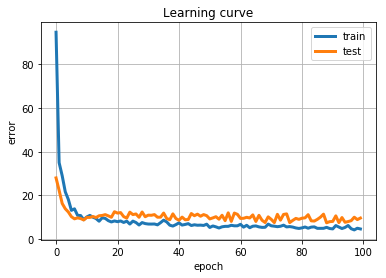

In [6]:
# Learning curve.
plt.plot(learning_curve, linewidth=3, label="train")
plt.plot(test_curve, linewidth=3, label="test")
plt.title("Learning curve")
plt.ylabel("error")
plt.xlabel("epoch")
plt.legend()
plt.grid()
plt.show()